In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score,GridSearchCV,RandomizedSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
import pickle

import warnings

warnings.filterwarnings("ignore")


In [2]:
cd D:\IABAC project\PROJECT

D:\IABAC project\PROJECT


Read the balanced data

In [3]:
X = pd.read_csv('data\\processed\\Independent_variables.csv')
y = pd.read_csv('data\\processed\\target_variables.csv')

In [4]:
y = y.values.reshape(-1)
y.shape

(2622,)

Splitting data into train test split

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
X_train.shape,X_test.shape

((1835, 23), (787, 23))

In [6]:
y_train.shape,y_test.shape

((1835,), (787,))

We splitted the data after balancing it because balancing after train test data split didn't yeilded good results.  

In [7]:
def evaluate_model(true, predicted):
    '''Function to calculate the metrics'''
    accuracy = accuracy_score(true,predicted)
    f1 = f1_score(true,predicted,average='weighted')
    precision = precision_score(true,predicted,average='weighted')
    recall = recall_score(true,predicted,average='weighted')
    
    return accuracy,f1,precision, recall

Following are the hyper parameters:

In [8]:
params={
        "Decision Tree": {
            'criterion':["gini", "entropy", "log_loss"],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        },
        "Random Forest":{
            'criterion':["gini", "entropy", "log_loss"],
            'n_estimators': [50, 100, 200], 
            'max_depth': [None, 10, 20], 
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        "Logistic Regression":{
            'C': [0.001, 0.01, 0.1, 1, 10, 100], 
            'penalty': ['l1', 'l2']
        },
        "KNN":{
            'n_neighbors': [3, 5, 7, 9], 
            'weights': ['uniform', 'distance'],
            'algorithm':['ball_tree','kd_tree','brute']
        },
        "GradientBoost":{
            'n_estimators': [50,100,200], 
            'learning_rate': [0.01, 0.1, 1], 
            'max_depth': [10, 20],
            'min_samples_split': [5, 10, 20],
            # 'min_samples_leaf': [1, 2, 4],
        },
        "XGBClassifier":{
            'max_depth': [10, 20, 30],
            'min_child_weight': [10, 20, 30],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'learning_rate':[1,.1,.01],
            'n_estimators': [8,16,32,64,128,256]
        },
        "CatBoostClassifier":{
            'iterations': [5,15,25],
            'depth': [10, 20],
            'learning_rate': [0.01, 0.1, 1],
        },
        "AdaBoost":{
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1]
        },
        "LightGBMClassifier":{
            'max_depth': [10, 20,30],
            'min_child_samples': [10, 20, 30],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'n_estimators': [50,100,200], 
            'learning_rate': [0.01, 0.1, 1],
            'reg_alpha':[0.1, 0.01, 1],
            'reg_lambda': [0.1, 0.01,1]           
           },
        "MLPClassifier" : {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'alpha': [0.0001, 0.001, 0.01]
        }

}


In [9]:
model_results= {}
class_mapping = {label: idx for idx, label in enumerate(np.unique(y_train))}
y_train_mapped = np.vectorize(class_mapping.get)(y_train)

class_mapping = {label: idx for idx, label in enumerate(np.unique(y_test))}
y_test_mapped = np.vectorize(class_mapping.get)(y_test)

def run_model(model_name, model):
    '''
    Function to run the model and return the results
    '''
    model.fit(X_train, y_train_mapped)  # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Map class labels for test set if needed
    y_test_mapped = np.vectorize(class_mapping.get)(y_test)
    
    # Evaluate Train and Test dataset
    model_train_accuracy, model_train_f1, model_train_precision, model_train_recall = evaluate_model(
        y_train_mapped, y_train_pred)
    model_test_accuracy, model_test_f1, model_test_precision, model_test_recall = evaluate_model(
        y_test_mapped, y_test_pred)

    cross_val_mean = cross_val_score(model, X_train, y_train_mapped, cv=5,scoring='f1_weighted').mean()
    cross_val_std = cross_val_score(model, X_train, y_train_mapped, cv=5,scoring='f1_weighted').std()

    print(model_name)
    
    # Saving the model as pickle file
    with open(f'data\\external\\{model_name}_model.pkl', 'wb') as file:
        pickle.dump(model, file)

    print('Model performance for Training set')
    print("- Accuracy : {:.4f}".format(model_train_accuracy))
    print("- F1_score : {:.4f}".format(model_train_f1))
    print("- Precision Score: {:.4f}".format(model_train_precision))
    print("- Recall Score: {:.4f}".format(model_train_recall))

    print('----------------------------------')

    print('Model performance for Test set')
    print("- Accuracy: {:.4f}".format(model_test_accuracy))
    print("- F1_score: {:.4f}".format(model_test_f1))
    print("- Precision Score: {:.4f}".format(model_test_precision))
    print("- Recall Score: {:.4f}".format(model_test_recall))

    print('----------------------------------')

    print("Crossvalidate Score(mean): {:.4f}".format(cross_val_mean))
    print("Crossvalidate Std: {:.4f}".format(cross_val_std))

    model_results[model_name] = {
          'accuracy_train':model_train_accuracy,
          'accuracy_test':model_test_accuracy,
          'f1_train':model_train_f1,
          'f1_test':model_test_f1 
        }

    print('=' * 35)

#     print('\n')

In [10]:
def hyper_tuning(model_name,model):
        '''
        Function to do hyperparameter tuning
        '''
        para = params[model_name]

        gs = RandomizedSearchCV(model,para,cv=5,scoring='f1_weighted',n_jobs=-1)
        gs.fit(X_train,y_train_mapped)
        
        model.set_params(**gs.best_params_)
        run_model(model_name,model)
        

In [11]:
hyper_tuning('Decision Tree',DecisionTreeClassifier(random_state=5))

Decision Tree
Model performance for Training set
- Accuracy : 0.9896
- F1_score : 0.9896
- Precision Score: 0.9897
- Recall Score: 0.9896
----------------------------------
Model performance for Test set
- Accuracy: 0.9250
- F1_score: 0.9251
- Precision Score: 0.9257
- Recall Score: 0.9250
----------------------------------
Crossvalidate Score(mean): 0.8996
Crossvalidate Std: 0.0168


In [12]:
hyper_tuning('Logistic Regression',LogisticRegression())

Logistic Regression
Model performance for Training set
- Accuracy : 0.8365
- F1_score : 0.8359
- Precision Score: 0.8361
- Recall Score: 0.8365
----------------------------------
Model performance for Test set
- Accuracy: 0.8183
- F1_score: 0.8172
- Precision Score: 0.8173
- Recall Score: 0.8183
----------------------------------
Crossvalidate Score(mean): 0.8268
Crossvalidate Std: 0.0232


In [13]:
run_model('KNN',KNeighborsClassifier())

KNN
Model performance for Training set
- Accuracy : 0.8512
- F1_score : 0.8413
- Precision Score: 0.8747
- Recall Score: 0.8512
----------------------------------
Model performance for Test set
- Accuracy: 0.7916
- F1_score: 0.7720
- Precision Score: 0.8206
- Recall Score: 0.7916
----------------------------------
Crossvalidate Score(mean): 0.7487
Crossvalidate Std: 0.0081


In [14]:
hyper_tuning('XGBClassifier',XGBClassifier(random_state=76))

XGBClassifier
Model performance for Training set
- Accuracy : 0.9967
- F1_score : 0.9967
- Precision Score: 0.9967
- Recall Score: 0.9967
----------------------------------
Model performance for Test set
- Accuracy: 0.9555
- F1_score: 0.9555
- Precision Score: 0.9556
- Recall Score: 0.9555
----------------------------------
Crossvalidate Score(mean): 0.9443
Crossvalidate Std: 0.0132


In [15]:
hyper_tuning('Random Forest',RandomForestClassifier(random_state=42))

Random Forest
Model performance for Training set
- Accuracy : 0.9978
- F1_score : 0.9978
- Precision Score: 0.9978
- Recall Score: 0.9978
----------------------------------
Model performance for Test set
- Accuracy: 0.9466
- F1_score: 0.9466
- Precision Score: 0.9467
- Recall Score: 0.9466
----------------------------------
Crossvalidate Score(mean): 0.9349
Crossvalidate Std: 0.0128


In [16]:
hyper_tuning('CatBoostClassifier',CatBoostClassifier())

0:	learn: 0.9979999	total: 204ms	remaining: 4.89s
1:	learn: 0.9311306	total: 273ms	remaining: 3.14s
2:	learn: 0.8650081	total: 345ms	remaining: 2.53s
3:	learn: 0.8062615	total: 418ms	remaining: 2.19s
4:	learn: 0.7613067	total: 491ms	remaining: 1.96s
5:	learn: 0.7089307	total: 559ms	remaining: 1.77s
6:	learn: 0.6674943	total: 623ms	remaining: 1.6s
7:	learn: 0.6328472	total: 688ms	remaining: 1.46s
8:	learn: 0.6051600	total: 753ms	remaining: 1.34s
9:	learn: 0.5746482	total: 819ms	remaining: 1.23s
10:	learn: 0.5484401	total: 882ms	remaining: 1.12s
11:	learn: 0.5271162	total: 949ms	remaining: 1.03s
12:	learn: 0.5052079	total: 1.01s	remaining: 934ms
13:	learn: 0.4840255	total: 1.08s	remaining: 847ms
14:	learn: 0.4650768	total: 1.14s	remaining: 759ms
15:	learn: 0.4460285	total: 1.2s	remaining: 676ms
16:	learn: 0.4265092	total: 1.26s	remaining: 594ms
17:	learn: 0.4080042	total: 1.32s	remaining: 515ms
18:	learn: 0.3909096	total: 1.39s	remaining: 438ms
19:	learn: 0.3779743	total: 1.45s	remaining

In [17]:
hyper_tuning('GradientBoost',GradientBoostingClassifier(random_state=42))

GradientBoost
Model performance for Training set
- Accuracy : 1.0000
- F1_score : 1.0000
- Precision Score: 1.0000
- Recall Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9568
- F1_score: 0.9568
- Precision Score: 0.9568
- Recall Score: 0.9568
----------------------------------
Crossvalidate Score(mean): 0.9346
Crossvalidate Std: 0.0147


In [18]:
hyper_tuning('AdaBoost',AdaBoostClassifier())

AdaBoost
Model performance for Training set
- Accuracy : 0.8932
- F1_score : 0.8922
- Precision Score: 0.8927
- Recall Score: 0.8932
----------------------------------
Model performance for Test set
- Accuracy: 0.8933
- F1_score: 0.8928
- Precision Score: 0.8926
- Recall Score: 0.8933
----------------------------------
Crossvalidate Score(mean): 0.8826
Crossvalidate Std: 0.0172


In [19]:
hyper_tuning('LightGBMClassifier',LGBMClassifier(force_row_wise=True))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total Bins 1776
[LightGBM] [Info] Number of data points in the train set: 1835, number of used features: 23
[LightGBM] [Info] Start training from score -1.124559
[LightGBM] [Info] Start training from score -1.078649
[LightGBM] [Info] Start training from score -1.093177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

In [20]:
hyper_tuning('MLPClassifier',MLPClassifier())

MLPClassifier
Model performance for Training set
- Accuracy : 0.9302
- F1_score : 0.9296
- Precision Score: 0.9313
- Recall Score: 0.9302
----------------------------------
Model performance for Test set
- Accuracy: 0.8653
- F1_score: 0.8627
- Precision Score: 0.8641
- Recall Score: 0.8653
----------------------------------
Crossvalidate Score(mean): 0.8561
Crossvalidate Std: 0.0147


In [21]:
lstm_model = Sequential()
lstm_model.add(LSTM(100,input_shape=(X_train.shape[1],1),activation='relu',return_sequences=True))
lstm_model.add(LSTM(50,activation='relu',return_sequences=True))
lstm_model.add(LSTM(20,activation='relu'))
lstm_model.add(Dense(3,activation='softmax'))
lstm_model.summary()
# lstm 100,50,30 dense 10


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 23, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 23, 50)            30200     
                                                                 
 lstm_2 (LSTM)               (None, 20)                5680      
                                                                 
 dense (Dense)               (None, 3)                 63        
                                                                 
Total params: 76743 (299.78 KB)
Trainable params: 76743 (299.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])  

In [23]:
history = lstm_model.fit(X_train, y_train_mapped, validation_split=0.3,batch_size=25,epochs=20)

Epoch 1/20


52/52 [==============================] - 5s 33ms/step - loss: 1.1001 - accuracy: 0.3731 - val_loss: 1.0951 - val_accuracy: 0.3884
Epoch 2/20
52/52 [==============================] - 1s 22ms/step - loss: 1.0824 - accuracy: 0.4089 - val_loss: 1.0792 - val_accuracy: 0.4610
Epoch 3/20
52/52 [==============================] - 1s 20ms/step - loss: 1.0812 - accuracy: 0.4221 - val_loss: 1.0785 - val_accuracy: 0.4828
Epoch 4/20
52/52 [==============================] - 1s 20ms/step - loss: 1.0598 - accuracy: 0.4751 - val_loss: 1.0669 - val_accuracy: 0.4664
Epoch 5/20
52/52 [==============================] - 1s 21ms/step - loss: 1.0129 - accuracy: 0.4953 - val_loss: 1.0174 - val_accuracy: 0.4719
Epoch 6/20
52/52 [==============================] - 1s 21ms/step - loss: 0.9506 - accuracy: 0.5350 - val_loss: 0.9221 - val_accuracy: 0.5626
Epoch 7/20
52/52 [==============================] - 1s 21ms/step - loss: 0.8892 - accuracy: 0.5436 - val_loss: 0.9353 - val_accuracy: 0.5572
Epoch 8/20


In [24]:
accuracy_test = lstm_model.evaluate(X_test,y_test_mapped,verbose=1)
accuracy_train = lstm_model.evaluate(X_train,y_train_mapped,verbose=1)


# accuracy_test, f1_test = evaluation_result_test[1], evaluation_result_test[2]
# accuracy_train, f1_train = evaluation_result_train[1], evaluation_result_train[2]

model_results['LSTM'] = {
    'accuracy_train':accuracy_train[1],
    'accuracy_test':accuracy_test[1],
    'f1_train':None, 
    'f1_test':None
}

print("Accuracy:", accuracy_test)
# print("F1 Score:", f1_test)

58/58 [==============================] - 0s 7ms/step - loss: 0.3895 - accuracy: 0.8425
Accuracy: [0.45371511578559875, 0.8081321716308594]


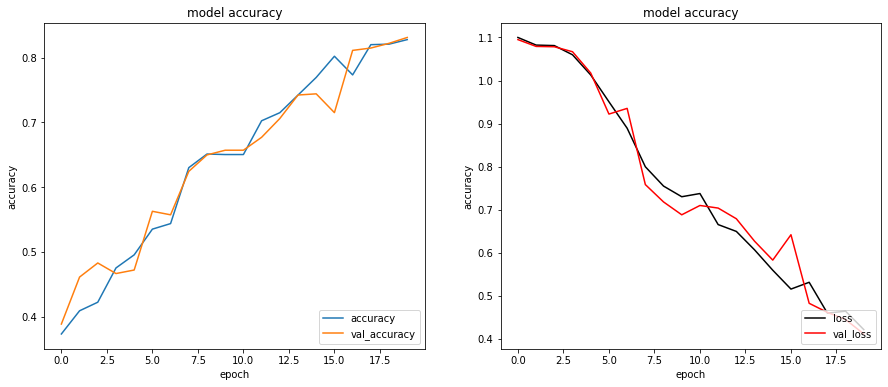

In [25]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label= 'val_accuracy')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
# plt.show()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='loss',color='k')
plt.plot(history.history['val_loss'], label= 'val_loss',color='r')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()

In [26]:
pd.DataFrame.from_dict(model_results,orient='index').sort_values(by=['f1_test','accuracy_test'],ascending=False)

,accuracy_train,accuracy_test,f1_train,f1_test
LightGBMClassifier,1.000000,0.959339,1.000000,0.959391
GradientBoost,1.000000,0.956798,1.000000,0.956778
XGBClassifier,0.996730,0.955527,0.996730,0.955513
Random Forest,0.997820,0.946633,0.997821,0.946574
Decision Tree,0.989646,0.925032,0.989645,0.925146
CatBoostClassifier,0.939510,0.913596,0.939465,0.913464
AdaBoost,0.893188,0.893266,0.892158,0.892829
MLPClassifier,0.930245,0.865311,0.929569,0.862675
Logistic Regression,0.836512,0.818297,0.835942,0.817171
KNN,0.851226,0.791614,0.841271,0.771986


## Insights

* `AdaBoost Classifier` has the least variation between training and testing parameters.
* `XGBoost Classifier`, `Random Forest` and `CatBoost Classifier` could also be considered as they have comparetively less variation between training and testing metrices.
* LightGBMClassifier, Decision Tree and GradientBoost models are overfitting even after hyperparametric tuning.
* Logistic Regression has the least score but it is a generalised model.
* The performance of `LSTM` is  equally good but couldn't calculate f1_score for that model. 
* Saved the best models as pickle file in the external directory 